In [ ]:
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = '/content/drive/MyDrive/muhendislik-tasarimi/dataset_yeni2/dataset/train'
test_path = '/content/drive/MyDrive/muhendislik-tasarimi/dataset_yeni2/dataset/test'
val_path = '/content/drive/MyDrive/muhendislik-tasarimi/dataset_yeni2/dataset/val'

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1/255) # Ölçeklendirme
test_data_gen = ImageDataGenerator(rescale=1/255)
val_data_gen = ImageDataGenerator(rescale=1/255)


In [ ]:
train_generator = train_data_gen.flow_from_directory(
        train_path,
        target_size=(224,224), # Görüntü boyutları
        batch_size=16,
        class_mode='categorical')  # Sınıf modu, çok sınıflı bir sınıflandırma olduğu için 'categorical'

Found 2889 images belonging to 4 classes.


In [ ]:
test_generator = test_data_gen.flow_from_directory(
    test_path,
    target_size=(224,224),  # Görüntü boyutları
    batch_size=16,
    class_mode='categorical'  # Sınıf modu, çok sınıflı bir sınıflandırma olduğu için 'categorical'
)

Found 363 images belonging to 4 classes.


In [ ]:
val_generator = val_data_gen.flow_from_directory(
    val_path,
    target_size=(224,224),  # Görüntü boyutları
    batch_size=16,
    class_mode='categorical'  # Sınıf modu, çok sınıflı bir sınıflandırma olduğu için 'categorical'
)

Found 358 images belonging to 4 classes.


In [ ]:
checkpoint = ModelCheckpoint(
    f'/content/drive/MyDrive/muhendislik-tasarimi/ResNet/resnet50_model3.h5',
     monitor='val_accuracy',
     verbose=1,
     save_best_only=True,
     mode = 'max'
)

In [ ]:
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          verbose=1,
                          mode = 'max')

In [ ]:
model = Sequential()
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.add(resnet)

model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.compile(optimizer='Adadelta', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Modeli eğitme
results = model.fit(train_generator, epochs=20, verbose=1, callbacks=[checkpoint,earlystop], validation_data= val_generator)


Epoch 1/20
181/181 [==============================] - ETA: 0s - loss: 1.5656 - accuracy: 0.2894
Epoch 1: val_accuracy improved from -inf to 0.24860, saving model to /content/drive/MyDrive/muhendislik-tasarimi/ResNet/resnet50_model3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


181/181 [==============================] - 218s 973ms/step - loss: 1.5656 - accuracy: 0.2894 - val_loss: 1.4308 - val_accuracy: 0.2486
Epoch 2/20
181/181 [==============================] - ETA: 0s - loss: 1.4067 - accuracy: 0.3614
Epoch 2: val_accuracy did not improve from 0.24860
181/181 [==============================] - 171s 944ms/step - loss: 1.4067 - accuracy: 0.3614 - val_loss: 1.6140 - val_accuracy: 0.2486
Epoch 3/20
181/181 [==============================] - ETA: 0s - loss: 1.2775 - accuracy: 0.4268
Epoch 3: val_accuracy improved from 0.24860 to 0.28771, saving model to /content/drive/MyDrive/muhendislik-tasarimi/ResNet/resnet50_model3.h5
181/181 [==============================] - 174s 959ms/step - loss: 1.2775 - accuracy: 0.4268 - val_loss: 1.5541 - val_accuracy: 0.2877
Epoch 4/20
181/181 [==============================] - ETA: 0s - loss: 1.1515 - accuracy: 0.4929
Epoch 4: val_accuracy improved from 0.28771 to 0.34916, saving model to /content/drive/MyDrive/muhendislik-tasarim

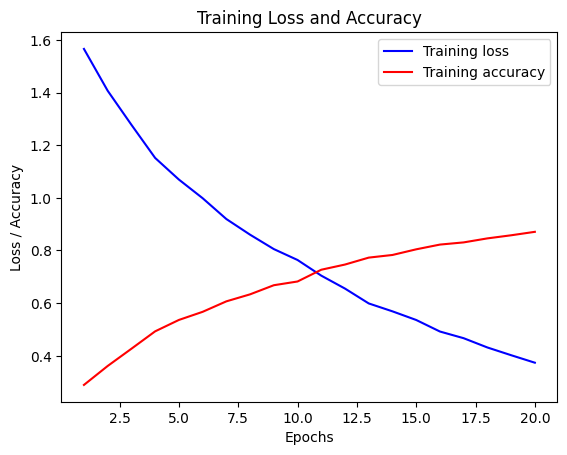

In [ ]:
import matplotlib.pyplot as plt
train_loss = results.history['loss']
train_accuracy = results.history['accuracy']

# train loss ve train accuracy görselleştirilmesi
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



23/23 [==============================] - 21s 935ms/step - loss: 0.2410 - accuracy: 0.9174
Test Loss: 0.24102024734020233
Test Accuracy: 0.9173553586006165


resnet50_model3 -> Test Loss: 0.24102024734020233
Test Accuracy: 0.9173553586006165


23/23 [==============================] - 21s 904ms/step


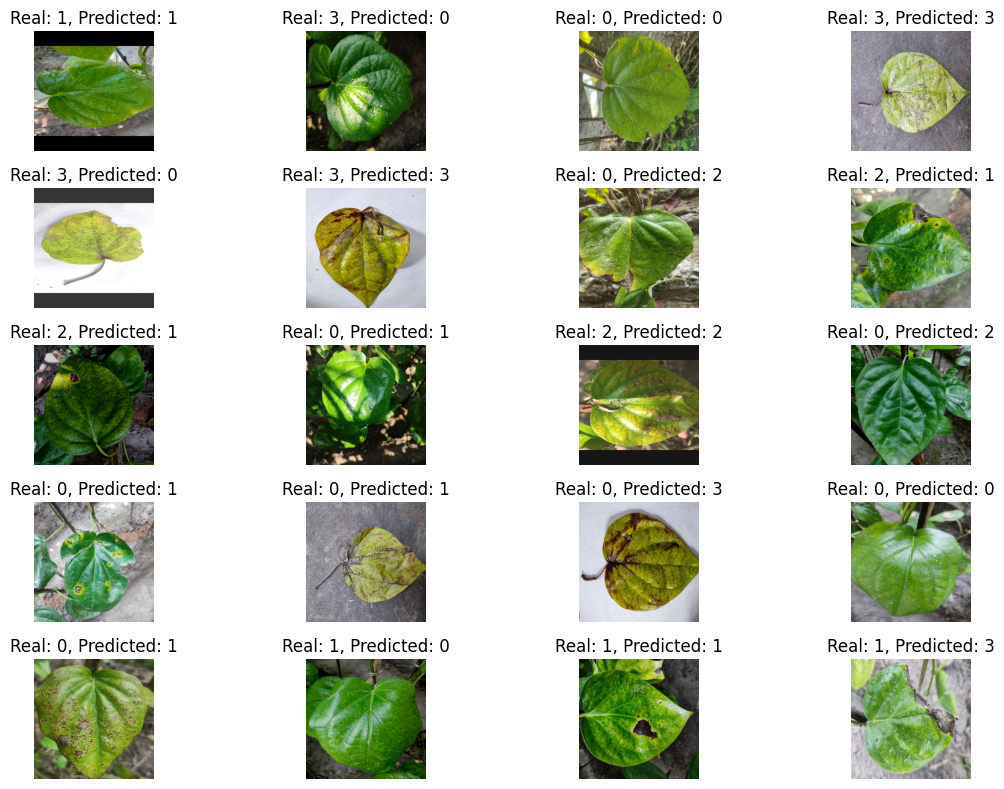

In [ ]:
#model ile tahmin (test verileriyle)
predictions = model.predict(test_generator)

# test verileri ve tahmin edilen değerler arasındaki karşılaştırma
num_samples_to_visualize = 20
test_labels = []  # Gerçek değerleri tutan boş liste
predicted_labels = []  # Tahmin edilen değerleri tutan boş liste

# Test verilerinden örnekleri al
for i, (_, labels) in enumerate(test_generator):
    test_labels.extend(labels.argmax(axis=1))  # Gerçek etiketleri al
    predicted_labels.extend(predictions.argmax(axis=1))  # Tahmin edilen etiketleri al
    if i == num_samples_to_visualize - 1:
        break

# Sonuçları görselleştir
plt.figure(figsize=(12, 8))
for i in range(num_samples_to_visualize):
    plt.subplot(5, 4, i + 1)
    plt.imshow(test_generator[i][0][0])  # Test resmini göster
    plt.title(f'Real: {test_labels[i]}, Predicted: {predicted_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()
